# CS146 Problem Set 1: Automated Inference with PyMC

## Problem 1. Fit a posterior

**Tasks:**

* Use PyMC to fit the model below to the data set provided below.
* Check that the sampler is working correctly. Show your work and explain why you think the sampler is or is not working as it should.
* Plot the posterior and interpret the results.

**Model:**

$$x \sim \text{Gamma}(\alpha=2,\beta=2)$$

$$y_i \sim \text{Poisson}(\lambda=x) \quad i=1,\ldots,20$$

### Solution

Given that the Gamma distribution is a **conjugate prior** for the Poisson distribution, we solve for the exact posterior in a closed form. Because our assumption is all 20 observations are **independent** given the parameters, the likelihood function can be written as a **product** of the Poisson distributions:

$$p(\mathbf{y} \mid \lambda)=∏_{i=1}^{n=20}p(y_i \mid \lambda)=\frac{\lambda^{y_i}e^{-\lambda}}{y_i!} ∝ \lambda^{∑_{i=1}^{n=20}y_i}e^{-n\lambda} = \lambda^{20\bar{y}}e^{-20\lambda}$$

where
$$\bar{\mathbf{y}}=\frac{1}{20}∑_{i=1}^{n=20}y_i=5.75$$

From there, the unnormalized posterior for the parameter $\lambda$ can be written as:

$$\begin{align*}
p(\lambda|\mathbf{y}) &\propto p(\mathbf{y}|\lambda)p(\lambda) \\
&\propto \lambda^{20\bar{y}}e^{-20\lambda}\lambda^{\alpha-1}e^{-\beta\lambda} \\
&= \lambda^{\alpha+20\bar{y}-1}e^{-(\beta+20)\lambda}\\
&= \lambda^{\alpha+115-1}e^{-(\beta+20)\lambda}
\end{align*}$$

We can recognize from the PDF of the gamma distribution, the posterior distribution is:

$$\lambda \mid \mathbf{Y} \sim \text{Gamma}(\alpha+115, \beta+20)$$
$$\lambda \mid \mathbf{Y} \sim \text{Gamma}(117, 22)$$


In [40]:
import matplotlib.pyplot as plt
import pymc as pm
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt

data = [9, 15, 4, 7, 7, 1, 3, 5, 8, 7, 9, 8, 4, 3, 0, 4, 6, 9, 2, 4]
data_mean = np.mean(data)
data_sum = np.sum(data)
num_obs = len(data)
print("Mean of dataset:", data_mean)
print("Sum of the dataset:", data_sum)
print("Number of observations in the dataset:", num_obs)

Mean of dataset: 5.75
Sum of the dataset: 115
Number of observations in the dataset: 20


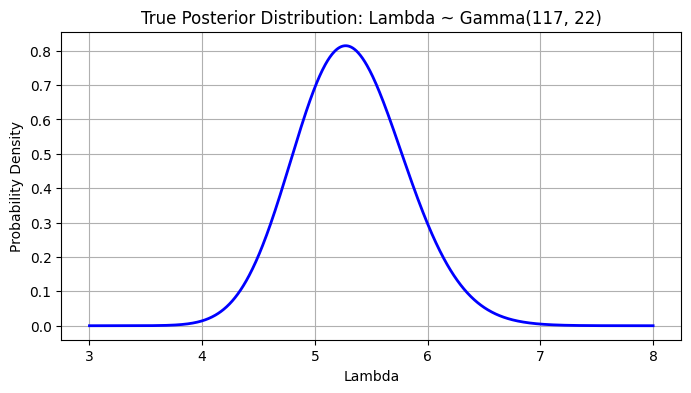

In [42]:
# Define the parameters of the posterior distribution
a_posterior = 2 + data_sum
b_posterior = 2 + num_obs

# Create a range of x values
x = np.linspace(3, 8, 1000)

# Calculate the posterior PDF
posterior = sts.gamma.pdf(x, a=a_posterior, scale=1/b_posterior)

# Plot the posterior distribution
plt.figure(figsize=(8, 4))
plt.plot(x, posterior, 'b-', lw=2)
plt.title(f'True Posterior Distribution: Lambda ~ Gamma({a_posterior}, {b_posterior})')
plt.xlabel('Lambda')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

In [16]:
# Sampling From True Posterior Distribution
with pm.Model() as model:
    x = pm.Gamma('x', alpha=2, beta=2)
    y_obs = pm.Poisson('y_obs',mu=x, observed=data)

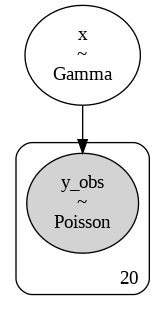

In [17]:
pm.model_to_graphviz(model)

from IPython.display import Image
Image(pm.model_to_graphviz(model).render(format='png'))

### Sampler Check
Before we proceed to the inference step, we need to check if our sampler is working correctly. To do this, we use **visual diagnostics**: trace plot and rank plot to check the sampling from **4 chains**. In general, if our sampler works well, there should be no significant and obvious differences among the chains' distributions and the sampler should **explore the full posterior distribution** instead of being stuck in a specific range of values.

In the **trace plot** below, it is clear that the **KDEs of 4 chains are almost the same**, with only small random differences. If we look at the plot on the right which record the values from sampled draws per chain per step. We can see that they look very "noisy" and random with no clear patterns, which makes it difficult to distinguish one chain from the other. This is a good thing because all 4 chains are exploring the same regions of the parameter space!

In the **rank plot**, it is clear that **all 4 ranks have a uniform distribution**. This indicates that they explored the full posterior distribution. Based on these results, we can be confident that our sampler works well. The summary table of inference also provides evidence that the sampler works well
- $\hat{R}$ is very close to 1, which is a good sign
- The effect sample sizes are very large (1635 for ess_bulk and 2737 for ess_tail). We want to make sure that consecutive samples are uncorrelated with each other. The effective sample size is a measure of how successful this was. So, if the effect size is large, it means that the sampling algorithm works well.

In [5]:
# Sample from 4 chains
with model:
    inference = pm.sample(chains=4)

all_x_samples = inference.posterior.x.values.flatten()

Output()

Output()

Output()

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,5.331,0.487,4.498,6.314,0.012,0.009,1635.0,2737.0,1.0


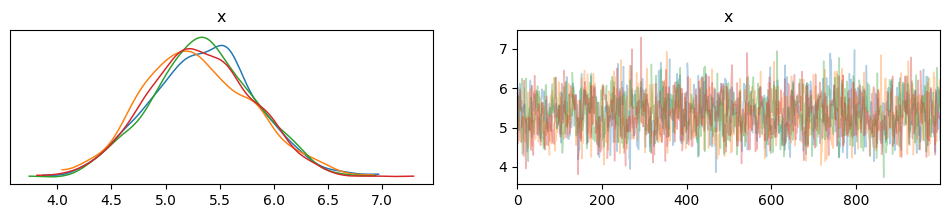

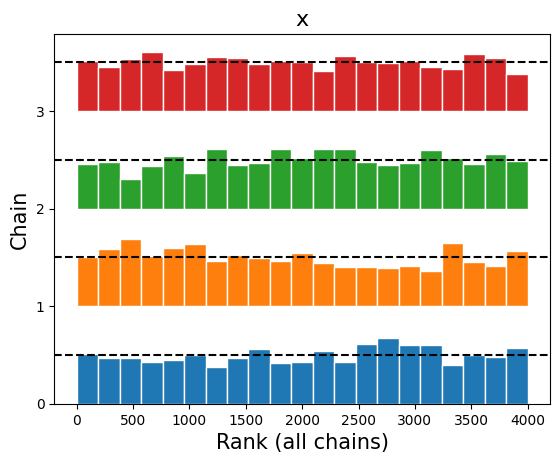

In [43]:
# Visual Diagnostics
import arviz as az

az.plot_trace(inference, compact=False)
az.plot_rank(inference)
az.summary(inference)

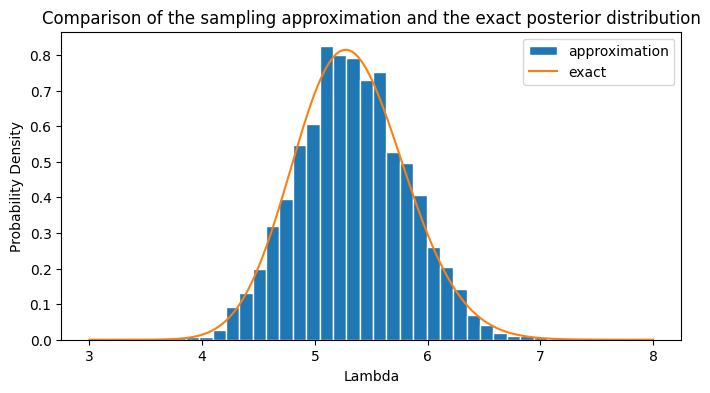

In [24]:
# Plot the posterior
plt.figure(figsize=(8, 4))
plt.title("Comparison of the sampling approximation and the exact posterior distribution")
plt.xlabel('Lambda')
plt.ylabel('Probability Density')
plt.hist(
    all_x_samples, bins=30, density=True,
    edgecolor='white', label='approximation'
)
x = np.linspace(3, 8, 1000)
y = sts.gamma.pdf(x, a=2+data_sum, scale=1/(2+num_obs))
plt.plot(x, y, label='exact')
plt.legend()
plt.show()

Based on the plot above, it is clear that the approximated posterior and the exact posterior distributions are well-overlapped. This means that the approximated inference works pretty well because it produces the results that align with the true posterior that we solved analytically.

## Problem 2. Create a prior

You are analyzing the battery performance of electric cars produced by a company. You want to model the range (in kilometers) that a car can travel on a full charge. There is some variability in ranges due to variations in battery chemistry.

The company expects that the median range of cars is 300 kilometers and that 90% of the cars have a range between 285 kilometers and 315 kilometers.

Tasks:
* Set up an appropriate model (likelihood and prior) to reflect the company's expectations about the battery performance of their electric cars.
* Motivate your choice of the likelihood function and prior distribution, explaining how they meet the specified criteria.
* Show that samples from your prior-predictive distribution have the percentiles indicated above. (This can be approximate but you have to quantify how close you are to the desired values.)

## Model Setup

The problem gives us the information about what properties the data distribution is expected to have. So our goal is to come up with a model that can generate samples of data that have a median range of 300 and 90% of the data points have a range between 285 and 315.

$$p(\tilde{R}) = \int_{\mu, \sigma} p(R \mid (\mu, \sigma))p(\mu)p(\sigma)d\mu d\sigma (*)$$

where $p(R \mid (\mu, \sigma))$ represents the likelihood function and $p(\mu)$, $p(\sigma)$ are the prior distributions over the parameters.

**Prior-Predictive Data Distribution**

Let's call $R$ the range (in kilometers) that a $i$-th car can travel on a full charge. Distances cannot be negative and their values can be continous. Given the constraint that $R$ can only take on **strictly positive continuous values and the provided information**, the data distribution of the prior-predictive follows a **log-normal** distribution with $m$ mean and $s$ standard deviation:

$$\tilde{R} ∼ \text{Lognormal}(\mu, \sigma)$$

As a result, we can compute its corresponding parameters:

- Median: $e^{\mu}=300 ⇒ \mu=\ln(300) \approx 5.7$

Given the 5th and 95th percentile of the data distribution, we can calculate the standard deviation:

$$q_X(\alpha)=e^{\mu+\sigma q_{\phi}(\alpha)}$$
where $q_{\phi}(\alpha)$ is the quantile of the standard normal distribution. We can look up the z-score table to find its corresponding quantiles.

- $e^{\mu + z_{0.05}\sigma}=285 ⇒ \mu - 1.645\sigma = \ln{285}$
- $e^{\mu + z_{0.95}\sigma}=315 ⇒ \mu + 1.645\sigma = \ln{315}$
- $\ln{315} - \ln{285} = 2\sigma ⇒ \sigma = \frac{\ln{315} - \ln{285}}{2 \times 1.645}=0.0304$
- Variance: $\sigma^2 = 0.000925$

In conclusion, the prior-predictive data distribution follows the log-normal distribution with the following parameters:

$$\tilde{R} \sim \text{Lognormal}(\mu=\ln{300}, \sigma=0.0304)$$

**Prior**

The prior represents the company's belief about the mean and the variance before any new data is observed. EV batteries have the ability to provide a range of **160–480 km** on a single charge, depending on the size and capacity of the battery (Koech et al.). Also, based on the report from [Electric Vehicle Database](https://ev-database.org/cheatsheet/range-electric-car), we are pretty certain that the **median range is around 300-350 (kms)**. **The company also believes that the median is 300**.

As a result, we can set the distribution for the mean as a **Truncated Normal distribution (with lower bound set to 0 to exclude negative values) with a small variance** to reflect our certainty about the mean.

$$\mu \sim \text{TruncatedNormal}(\mu_0=\ln{300}, \sigma_0=0.01, a=0, b=+\infty)$$

The company expects to see some variability in the ranges due to variations in battery chemistry. We assume that they are also pretty certain about the variance because the available literature indicates that there are not too many rare ranges (extremely high or low) that signals extreme variance. Therefore, we can use the **Inverse Gamma Distribution** to model the variance. I-G distribution is appropriate because **its support is $(0, ∞)$** which meets the constraint that variance cannot be negative (from the values of variance, we can estimate the standard deviation by taking the principle square root):

$$\sigma^2 \sim \text{Inverse-Gamma}(\alpha, \beta)$$

Large $\alpha$ and low $\beta$ reflects our certainty about the variance. We want a distribution such that the prior variance is highly concentrated around $s^2 = 0.000925$
- Mean of the Inverse Gamma distribution is: $\frac{\beta}{\alpha-1}=0.000925$
- Let's set $\alpha=100$, we get $\beta \approx 0.092$

**Likelihood**

The likelihood tells us how likely it is to observe range $R$ given the prior parameters $\mu$ and $\sigma$. Revisiting $(*)$ and the prior distributions we specified above, we also set up the likelihood of $R$ as the **log-normal likelihood** with $m$ mean and $s$ standard deviation.

In other words, the prior-predictive distribution is the result of the integration of the likelihood over all possible values of the priors. We know that the prior-predictive follows a log-normal distribution and the priors are highly certain values, the likelihood is highly likely to be a log-normal distribution.
$$R \sim \text{Lognormal}(m=\ln{300}, s=0.0304)$$

To check if this model setup is a reasonable one, we just need to sample from the prior-predictive to see if the sample we approximated match the information: median range equals to 300 and 90% of the data points fall within [285, 315].

In [65]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

mu = np.log(300)
sigma = (np.log(315) - np.log(285)) / (2 * 1.645)
var = sigma**2
alpha = 100
beta = var * (alpha - 1)
print("The mean of the data (mu): ", mu)
print("The standard deviation of the data (sigma): ", sigma)
print("The variance of the data (var): ", var)
print("The parameter beta of the inverse gamma distribution is: ", beta)

The mean of the data (mu):  5.703782474656201
The standard deviation of the data (sigma):  0.030420504120663314
The variance of the data (var):  0.0009254070709552937
The parameter beta of the inverse gamma distribution is:  0.09161530002457408


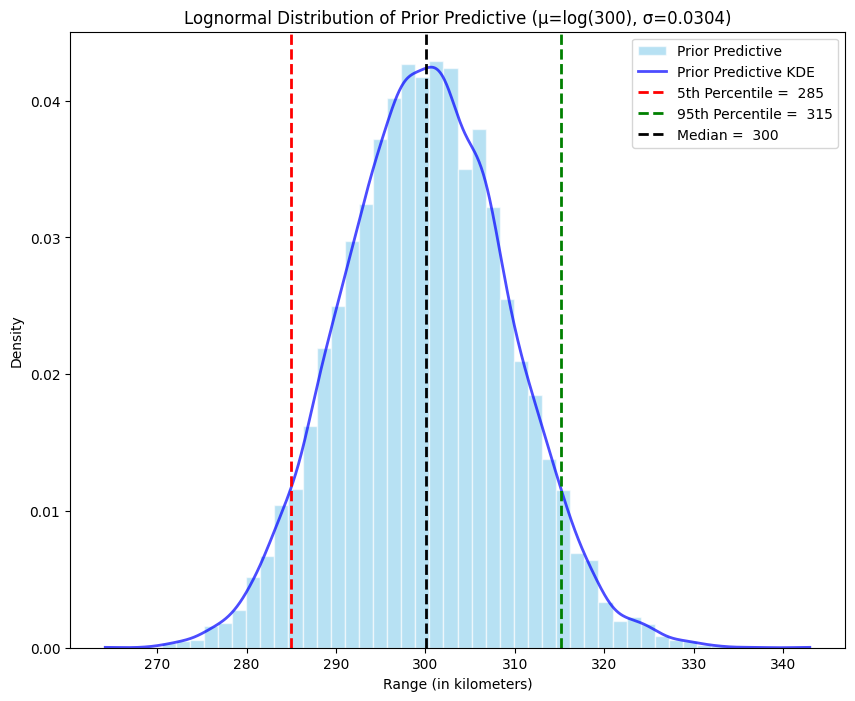

5th percentile: 284.97 km
Median: 300.03 km
95th percentile: 315.15 km

Difference from desired values:
5th percentile: 0.03 km
Median: 0.03 km
95th percentile: 0.15 km

Proportion of cars between 285 and 315 km: 0.8972


In [164]:
import scipy.stats as sts

# Create a PyMC model
with pm.Model() as model:
    # Prior Distributions
    mu = pm.TruncatedNormal('mu', mu=np.log(300), sigma=0.001, lower=0)
    sigma_squared = pm.InverseGamma('sigma_squared', alpha=alpha, beta=beta)
    sigma_0 = np.sqrt(sigma_squared)

    # Likelihood with no observed data
    pm.LogNormal('R', mu=mu, sigma=sigma_0, observed=None)

# Number of prior predictive samples
n_samples = 10000

# Draw prior predictive samples
with model:
    inference = pm.sample_prior_predictive(n_samples)

# Extract prior samples
prior_mu = inference.prior['mu'].values.ravel()
prior_sigma = np.sqrt(inference.prior['sigma_squared'].values).ravel()
prior_predictive = inference.prior['R'].values.ravel()

# Calculate percentiles
p5, median, p95 = np.percentile(prior_predictive, [5, 50, 95])

# Create the plot
plt.figure(figsize=(10, 8))

# Plot histogram of prior predictive samples
plt.hist(prior_predictive, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='white', label='Prior Predictive')

# Probability Density Function for prior predictive
kde = stats.gaussian_kde(prior_predictive)
x_range = np.linspace(prior_predictive.min(), prior_predictive.max(), 1000)
plt.plot(x_range, kde(x_range), color='blue', alpha=0.7, linewidth=2, label='Prior Predictive KDE')
plt.axvline(p5, color='red', linestyle='dashed', linewidth=2, label=f'5th Percentile = {p5: .0f}')
plt.axvline(p95, color='green', linestyle='dashed', linewidth=2, label=f'95th Percentile = {p95: .0f}')
plt.axvline(median, color='black', linestyle='dashed', linewidth=2, label=f'Median = {median: .0f}')
plt.title(f'Lognormal Distribution of Prior Predictive (μ=log(300), σ={sigma:.4f})')
plt.xlabel('Range (in kilometers)')
plt.ylabel('Density')
plt.legend()
plt.show()

print(f"5th percentile: {p5:.2f} km")
print(f"Median: {median:.2f} km")
print(f"95th percentile: {p95:.2f} km")

# Calculate how close we are to the desired values
print(f"\nDifference from desired values:")
print(f"5th percentile: {abs(p5 - 285):.2f} km")
print(f"Median: {abs(median - 300):.2f} km")
print(f"95th percentile: {abs(p95 - 315):.2f} km")

# Calculate the proportion of cars between 285 and 315 km
prop_within_range = np.mean((prior_predictive >= 285) & (prior_predictive <= 315))
print(f"\nProportion of cars between 285 and 315 km: {prop_within_range:.4f}")

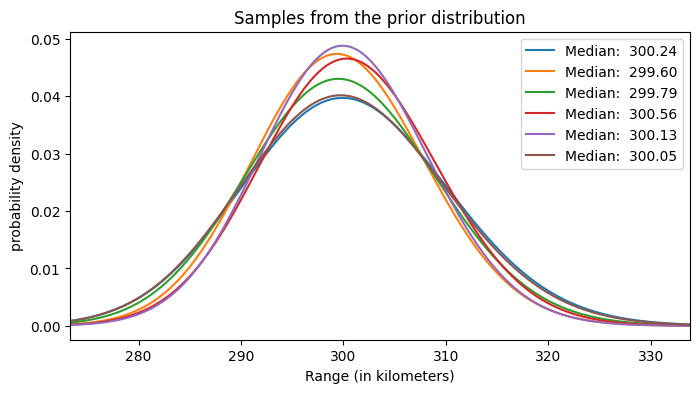

In [172]:
# Generate prior and prior-predictive samples with PyMC

# Extract prior samples
prior_mu = inference.prior['mu'].values.ravel()
prior_sigma = np.sqrt(inference.prior['sigma_squared'].values).ravel()
prior_predictive = inference.prior['R'].values.ravel()

# Each PDF represents a possible data distribution
x_range = np.linspace(prior_predictive.min(), prior_predictive.max(), 1000)
plt.figure(figsize=(8, 4))
plt.title('Samples from the prior distribution')
plt.xlabel('Range (in kilometers)')
plt.ylabel('probability density')

# Create 6 sampled lognormal pdf
for i in range(6):
    plot_y = sts.lognorm.pdf(
        x_range, s=prior_sigma[i], scale=np.exp(prior_mu[i]))
    plt.plot(x_range, plot_y, label=f'Median: {np.exp(prior_mu[i]): .2f}')
    plt.xlim(x_range[0], x_range[-1])
    plt.legend()

plt.show()

### Samples from Prior-Predictive

In this code cell, we will create 5 samples from the prior-predictive to check if they match the information given in the problem

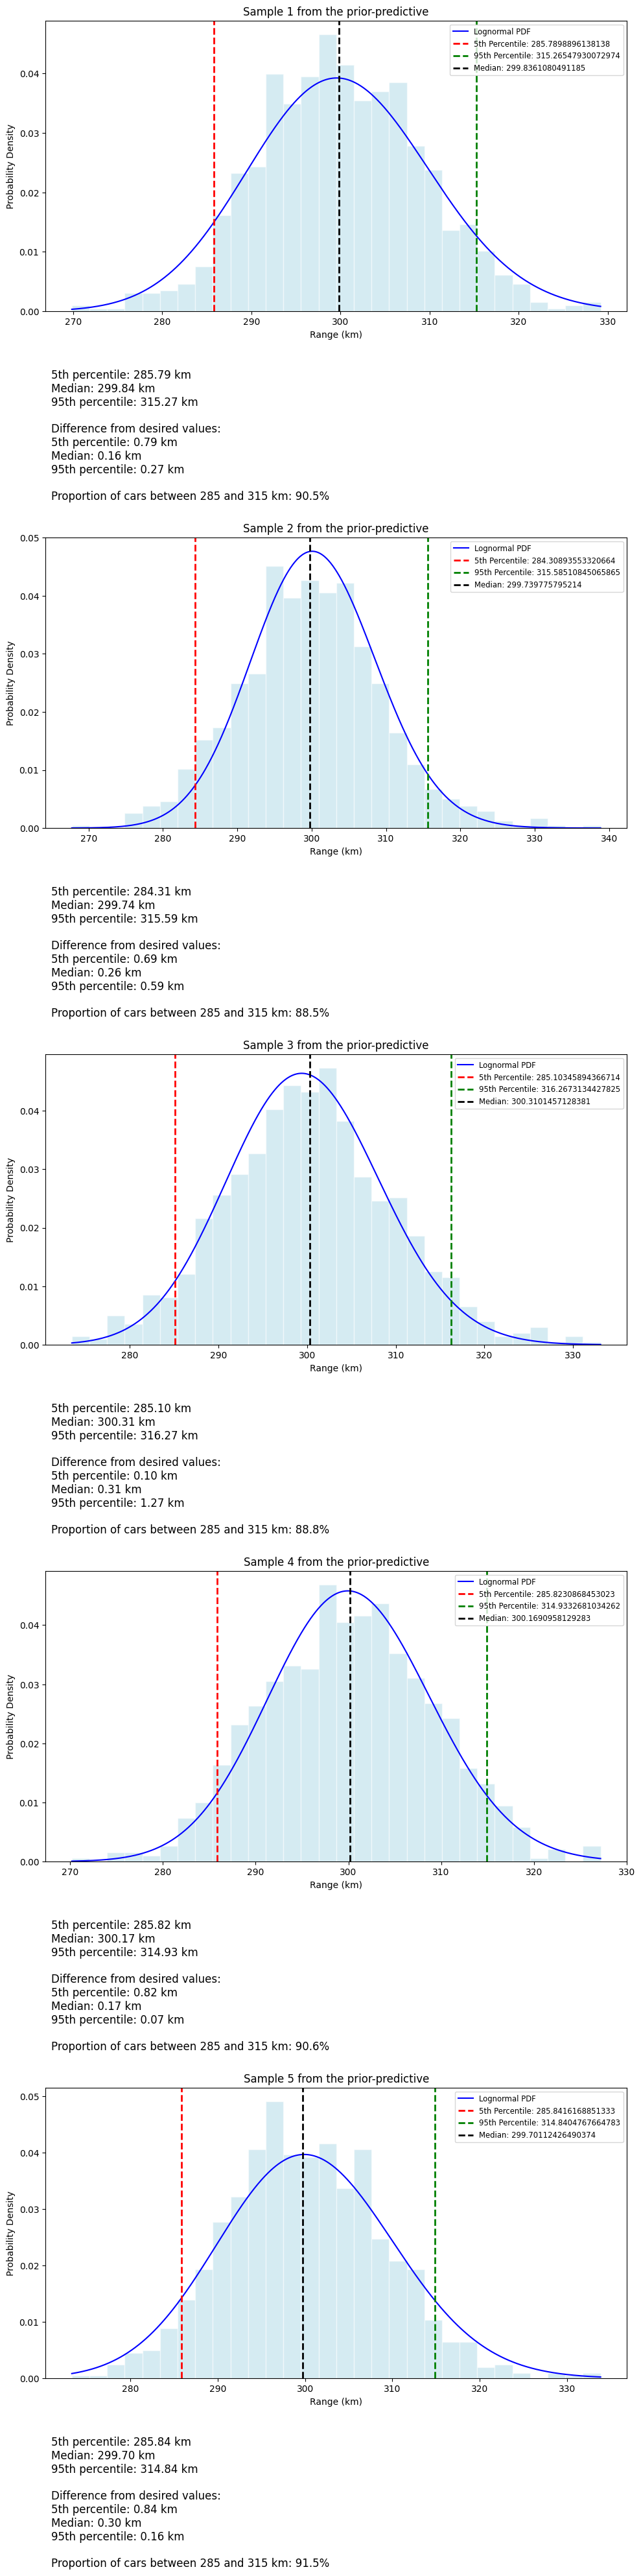

In [167]:
# Create a function to generate one sample
def generate_sample():
    with pm.Model() as model:
        mu_prior = pm.TruncatedNormal('mu', mu=mu, sigma=0.001, lower=0)
        sigma_squared = pm.InverseGamma('sigma_squared', alpha=alpha, beta=beta)
        sigma_0 = np.sqrt(sigma_squared)
        pm.LogNormal('R', mu=mu_prior, sigma=sigma_0, observed=None)
        inference = pm.sample_prior_predictive(1000)

    return inference

# Generate 5 samples
samples = [generate_sample() for _ in range(5)]

# Create the plot
fig, axes = plt.subplots(5, 1, figsize=(10, 40))
axes = axes.ravel()

for i, (ax, inference) in enumerate(zip(axes, samples)):
    # Extract values sampled from the prior and prior-predictive
    prior_mu = inference.prior['mu'].values.ravel()
    prior_sigma = np.sqrt(inference.prior['sigma_squared'].values).ravel()
    prior_predictive = inference.prior['R'].values.ravel()

    # Calculate the percentiles
    p5, median, p95 = np.percentile(prior_predictive, [5, 50, 95])

    # Plot histogram
    ax.hist(prior_predictive, bins=30, density=True, alpha=0.5, color='lightblue', edgecolor='white')

    # Plot lognormal PDF
    x_range = np.linspace(prior_predictive.min(), prior_predictive.max(), 1000)
    plot_y = sts.lognorm.pdf(x_range, s=prior_sigma[0], scale=np.exp(prior_mu[0]))
    ax.plot(x_range, plot_y, color='blue', label='Lognormal PDF')

    # Plot percentiles
    ax.axvline(p5, color='red', linestyle='dashed', linewidth=2, label=f'5th Percentile: {p5}')
    ax.axvline(p95, color='green', linestyle='dashed', linewidth=2, label=f'95th Percentile: {p95}')
    ax.axvline(median, color='black', linestyle='dashed', linewidth=2, label=f'Median: {median}')

    ax.set_title(f'Sample {i+1} from the prior-predictive')
    ax.set_xlabel('Range (km)')
    ax.set_ylabel('Probability Density')
    ax.legend(loc='upper right', fontsize='small')

    # Add text below the plot
    stats_text = (
        f"5th percentile: {p5:.2f} km\n"
        f"Median: {median:.2f} km\n"
        f"95th percentile: {p95:.2f} km\n"
        f"\nDifference from desired values:\n"
        f"5th percentile: {abs(p5 - 285):.2f} km\n"
        f"Median: {abs(median - 300):.2f} km\n"
        f"95th percentile: {abs(p95 - 315):.2f} km\n"
        f"\nProportion of cars between 285 and 315 km: {(np.mean((prior_predictive >= 285) & (prior_predictive <= 315)))*100:.1f}%"
    )
    ax.text(0.01, -0.2, stats_text, transform=ax.transAxes, verticalalignment='top', fontsize=12)

plt.tight_layout()
plt.show()

- Based on 5 plots above, it is clear that our model works pretty well because all 5 samples are aligned with the given information. We use the absolute difference to quantify the difference between the approximated values and the desired values. The differences are very small, around 1 uni (in kilometer) away from the desired output.

- All approximated samples have $\sim 90\%$ of the data points fall within the range of $285$ and $315$ (kilometers).

### Alternative Models

Besides the model that we set up above, two slightly different models can also be used in this scenario.

1.   Instead of using the Inverse-Gamma Distribution for the variance, we can use the **Half-normal distribution** to model the standard deviation $\sigma$ because the support of the Half-normal distribution is $[0, \infty]$. This also meets our constraint about the positivity of the standard deviation.
$$\sigma \sim \text{Half-normal}(\sigma_1)$$
We can choose **low scale parameter** to reflect the company's certainty about the variability of the range (in kilometers). The resulting shape of the prior-predictive distribution will be a little different from the initial model where we use Inverse-Gamma.
2.   Another way to set up this model is to fix the mean $\mu$ and the standard deviation $\sigma$. This means that we treat the two parameters as **known**, implying that the company is very certain about the parameters such that the variability is negligible.
$$\mu=5.7, \sigma=0.0304$$

Both models also give us the same prior-predictive data distribution aligned with the company's expectations. However, we only know which one is the best when we acquire more data.



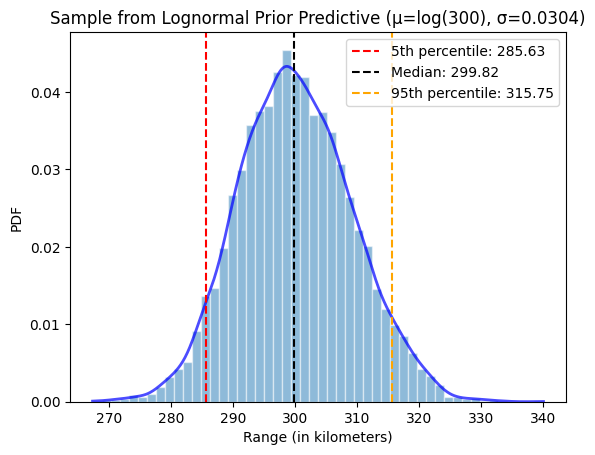

Median of X: 299.82 km
5th percentile of X: 285.63 km
95th percentile of X: 315.75 km
Proportion of cars between 285 km and 315 km: 0.9001


In [204]:
# Fixed parameters based on company's expectations
mu_value = np.log(300)
sigma_value = sigma

with pm.Model() as model:
    # Likelihood (no observed data)
    X = pm.LogNormal('X', mu=mu, sigma=sigma_value)

# Number of prior predictive samples
n_samples = 10000

# Draw prior predictive samples
with model:
    inference = pm.sample_prior_predictive(n_samples)

# Extract prior samples
prior_predictive = inference.prior['X'].values.ravel()

# Calculate percentiles
median_X = np.median(prior_predictive)
p5 = np.percentile(prior_predictive, 5)
p95 = np.percentile(prior_predictive, 95)


# Plot histogram of prior predictive samples
kde = stats.gaussian_kde(prior_predictive)
x_range = np.linspace(prior_predictive.min(), prior_predictive.max(), 1000)
plt.plot(x_range, kde(x_range), color='blue', alpha=0.7, linewidth=2)
plt.hist(prior_predictive, bins=50, density=True, alpha=0.5, edgecolor='white')
plt.axvline(x=p5, color='red', linestyle='--', label=f'5th percentile: {p5:.2f}')
plt.axvline(x=median_X, color='black', linestyle='--', label=f'Median: {median_X:.2f}')
plt.axvline(x=p95, color='orange', linestyle='--', label=f'95th percentile: {p95:.2f}')
plt.title(f'Sample from Lognormal Prior Predictive (μ=log(300), σ={sigma_value:.4f})')
plt.xlabel('Range (in kilometers)')
plt.ylabel('PDF')
plt.legend()
plt.show()


print(f"Median of X: {median_X:.2f} km")
print(f"5th percentile of X: {p5:.2f} km")
print(f"95th percentile of X: {p95:.2f} km")

# Proportion between 285 km and 315 km
prop_between = np.mean((prior_predictive >= 285) & (prior_predictive <= 315))
print(f"Proportion of cars between 285 km and 315 km: {prop_between:.4f}")


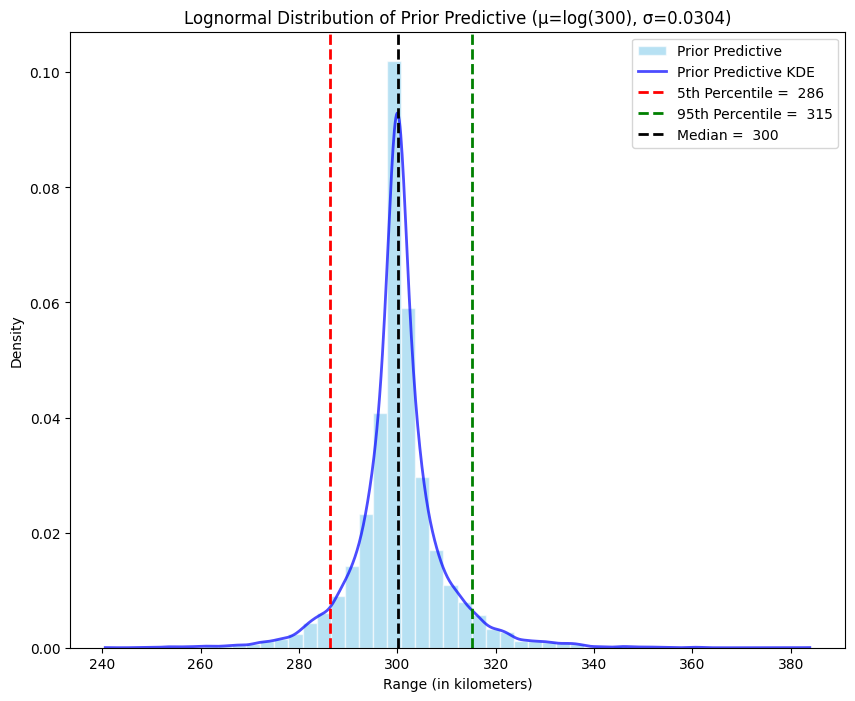

5th percentile: 286.26 km
Median: 300.05 km
95th percentile: 315.10 km

Difference from desired values:
5th percentile: 1.26 km
Median: 0.05 km
95th percentile: 0.10 km

Proportion of cars between 285 and 315 km: 0.9075


In [185]:
 # Create a PyMC model
with pm.Model() as model:
    # Prior Distributions
    mu = pm.TruncatedNormal('mu', mu=np.log(300), sigma=0.001, lower=0)
    sigma_0 = pm.HalfNormal('sigma', sigma=0.03)

    # Likelihood with no observed data
    pm.LogNormal('R', mu=mu, sigma=sigma_0, observed=None)

# Number of prior predictive samples
n_samples = 10000

# Draw prior predictive samples
with model:
    inference = pm.sample_prior_predictive(n_samples)

# Extract prior samples
prior_mu = inference.prior['mu'].values.ravel()
prior_sigma = inference.prior['sigma'].values.ravel()
prior_predictive = inference.prior['R'].values.ravel()

# Calculate percentiles
p5, median, p95 = np.percentile(prior_predictive, [5, 50, 95])

# Create the plot
plt.figure(figsize=(10, 8))

# Plot histogram of prior predictive samples
plt.hist(prior_predictive, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='white', label='Prior Predictive')

# Probability Density Function for prior predictive
kde = stats.gaussian_kde(prior_predictive)
x_range = np.linspace(prior_predictive.min(), prior_predictive.max(), 1000)
plt.plot(x_range, kde(x_range), color='blue', alpha=0.7, linewidth=2, label='Prior Predictive KDE')
plt.axvline(p5, color='red', linestyle='dashed', linewidth=2, label=f'5th Percentile = {p5: .0f}')
plt.axvline(p95, color='green', linestyle='dashed', linewidth=2, label=f'95th Percentile = {p95: .0f}')
plt.axvline(median, color='black', linestyle='dashed', linewidth=2, label=f'Median = {median: .0f}')
plt.title(f'Lognormal Distribution of Prior Predictive (μ=log(300), σ={sigma:.4f})')
plt.xlabel('Range (in kilometers)')
plt.ylabel('Density')
plt.legend()
plt.show()

print(f"5th percentile: {p5:.2f} km")
print(f"Median: {median:.2f} km")
print(f"95th percentile: {p95:.2f} km")

# Calculate how close we are to the desired values
print(f"\nDifference from desired values:")
print(f"5th percentile: {abs(p5 - 285):.2f} km")
print(f"Median: {abs(median - 300):.2f} km")
print(f"95th percentile: {abs(p95 - 315):.2f} km")

# Calculate the proportion of cars between 285 and 315 km
prop_within_range = np.mean((prior_predictive >= 285) & (prior_predictive <= 315))
print(f"\nProportion of cars between 285 and 315 km: {prop_within_range:.4f}")


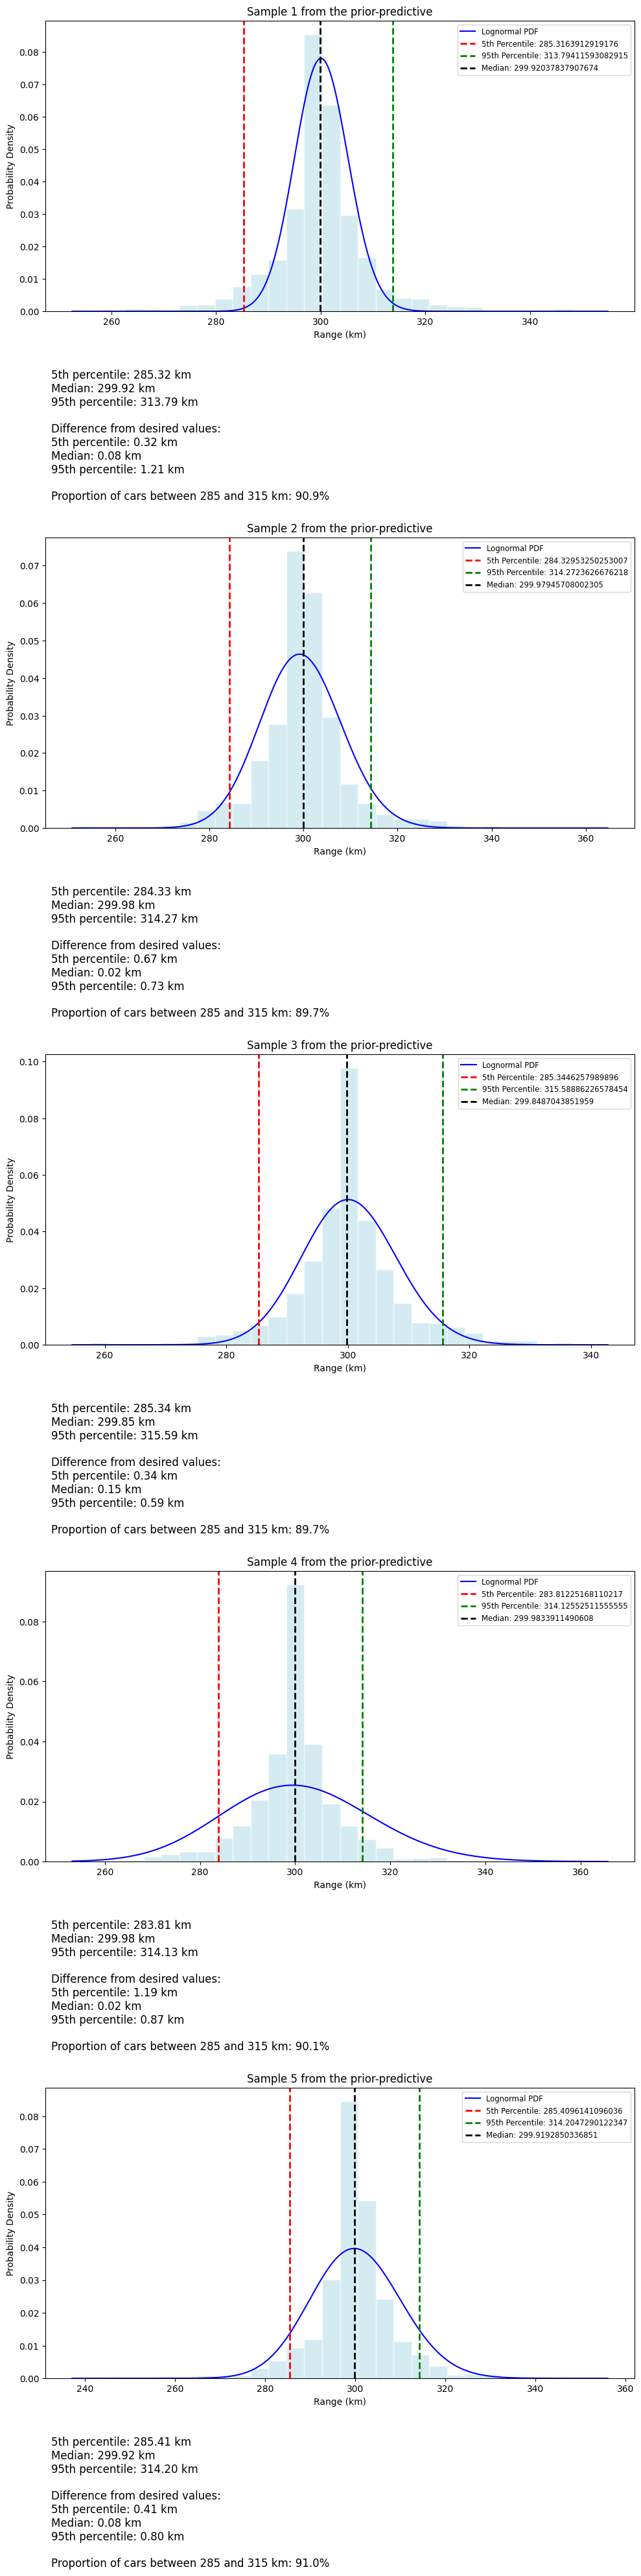

In [186]:
# Create a function to generate one sample
def generate_sample():
    with pm.Model() as model:
        mu_prior = pm.TruncatedNormal('mu', mu=mu, sigma=0.001, lower=0)
        sigma_0 = pm.HalfNormal('sigma', sigma=0.03)
        pm.LogNormal('R', mu=mu_prior, sigma=sigma_0, observed=None)
        inference = pm.sample_prior_predictive(1000)
    return inference

# Generate 5 samples
samples = [generate_sample() for _ in range(5)]

# Create the plot
fig, axes = plt.subplots(5, 1, figsize=(10, 40))
axes = axes.ravel()

for i, (ax, inference) in enumerate(zip(axes, samples)):
    # Extract values sampled from the prior and prior-predictive
    prior_mu = inference.prior['mu'].values.ravel()
    prior_sigma = inference.prior['sigma'].values.ravel()
    prior_predictive = inference.prior['R'].values.ravel()

    # Calculate the percentiles
    p5, median, p95 = np.percentile(prior_predictive, [5, 50, 95])

    # Plot histogram
    ax.hist(prior_predictive, bins=30, density=True, alpha=0.5, color='lightblue', edgecolor='white')

    # Plot lognormal PDF
    x_range = np.linspace(prior_predictive.min(), prior_predictive.max(), 1000)
    plot_y = sts.lognorm.pdf(x_range, s=prior_sigma[0], scale=np.exp(prior_mu[0]))
    ax.plot(x_range, plot_y, color='blue', label='Lognormal PDF')

    # Plot percentiles
    ax.axvline(p5, color='red', linestyle='dashed', linewidth=2, label=f'5th Percentile: {p5}')
    ax.axvline(p95, color='green', linestyle='dashed', linewidth=2, label=f'95th Percentile: {p95}')
    ax.axvline(median, color='black', linestyle='dashed', linewidth=2, label=f'Median: {median}')

    ax.set_title(f'Sample {i+1} from the prior-predictive')
    ax.set_xlabel('Range (km)')
    ax.set_ylabel('Probability Density')
    ax.legend(loc='upper right', fontsize='small')

    # Add text below the plot
    stats_text = (
        f"5th percentile: {p5:.2f} km\n"
        f"Median: {median:.2f} km\n"
        f"95th percentile: {p95:.2f} km\n"
        f"\nDifference from desired values:\n"
        f"5th percentile: {abs(p5 - 285):.2f} km\n"
        f"Median: {abs(median - 300):.2f} km\n"
        f"95th percentile: {abs(p95 - 315):.2f} km\n"
        f"\nProportion of cars between 285 and 315 km: {(np.mean((prior_predictive >= 285) & (prior_predictive <= 315)))*100:.1f}%"
    )
    ax.text(0.01, -0.2, stats_text, transform=ax.transAxes, verticalalignment='top', fontsize=12)

plt.tight_layout()
plt.show()

## References